In [23]:
#Nombre del archivo
csv_path = "Cliente_segmentacion_v0.csv"

In [24]:
import os #Sirve para trabajar con archivos del S.O
#Verifica si la ruta del archivo existe
assert os.path.exists(csv_path), f"No se encuentra el Archivo"

In [25]:
import pandas as pd 
#sirve para trabajar con datos de archivos .CSV, .xlsx, .json
df = pd.read_csv(csv_path, sep=";")
#Lee el archivo CSV con la variable de la ruta antes declarada
#read_csv puede recibir parametros como:
#sep=";" o "," -> las columnas están separadadas por ; o ,
#decimal="," -> Útil si los números usan , en vez de .
#thousands="." -> manejar separadores de miles
#dtype={"col": tipo} -> fuerza el tipo de dato de una columna
#parse_dates=["colFecha"] -> columnas a formato fecha (datetime)
#infer_datetime_format=True -> Hace más rapido el parseo de fechas
#na_values=["NA", "Not Available", "null", "Null"]
# trata estos valores como nulos
#encoding="latin1 o utf-8"
# sirve para leer archivos con tildes y/o caracteres especiales

In [26]:
df.head() 
#Muestra las primeras 5 filas del DataFrame
df.shape 
#Muestra la dimensionalidad del DataFrame (filas X columnas)
df.dtypes 
#Muestra el tipo de dato de cada columna

Id                     int64
Edad                 float64
NivEdua              float64
AnhosEmpleo          float64
IngresoMensual        object
DeudaTarjeta         float64
OtraDeuda            float64
Quiebra                int64
Direccion             object
RatioIngresoDeuda    float64
dtype: object

In [27]:
df.describe() 
#Genera un resumen estadístico de las columnas númericas
#count -> Cantidad de valores no nulos; 
#mean -> Promedio (media aritmética)
#std Desviación estándar (que tan dispersos están los datos) ; 
#min -> El valor mínimo de la columna
#25% -> Percentil 25 o cuartil 1 (el 25% de los datos está por debajo);
#50% -> Percentil 50 o mediana
#75% -> Percentil 75 o cuartil 3 (el 75% de los datos está por debajo); 
#Max -> El valor máximo de la columna
#describe() puede recibir otro parametro como:
#describe(include="all") -> Incluye las columnas de texto/categoríca
#describe(include=[object] o [float]) -> incluye solo las columnas que se especifican
#describe(exclude=[int]) -> excluye datos
#describe(percentiles=[0.1, 0.9]) -> cambia los percentiles que se muestran (10% y 90%)

,Id,Edad,NivEdua,AnhosEmpleo,DeudaTarjeta,OtraDeuda,Quiebra,RatioIngresoDeuda
count,1000.000000,950.000000,950.000000,950.000000,950.000000,950.000000,1000.000000,950.000000
mean,500.500000,46.429474,2.604211,27.936842,4.231071,3.673019,0.438000,10.672716
std,288.819436,14.986147,1.135305,14.263005,5.505800,4.727036,0.496389,14.893755
min,1.000000,21.000000,1.000000,0.000000,0.593000,0.296000,0.000000,1.170000
25%,250.750000,34.000000,2.000000,16.000000,2.345500,2.118000,0.000000,4.380000
50%,500.500000,47.000000,3.000000,29.000000,3.032000,2.736500,0.000000,6.610000
75%,750.250000,59.000000,4.000000,41.000000,3.908000,3.538000,1.000000,11.410000
max,1000.000000,70.000000,4.000000,60.000000,76.456000,71.024000,1.000000,205.760000


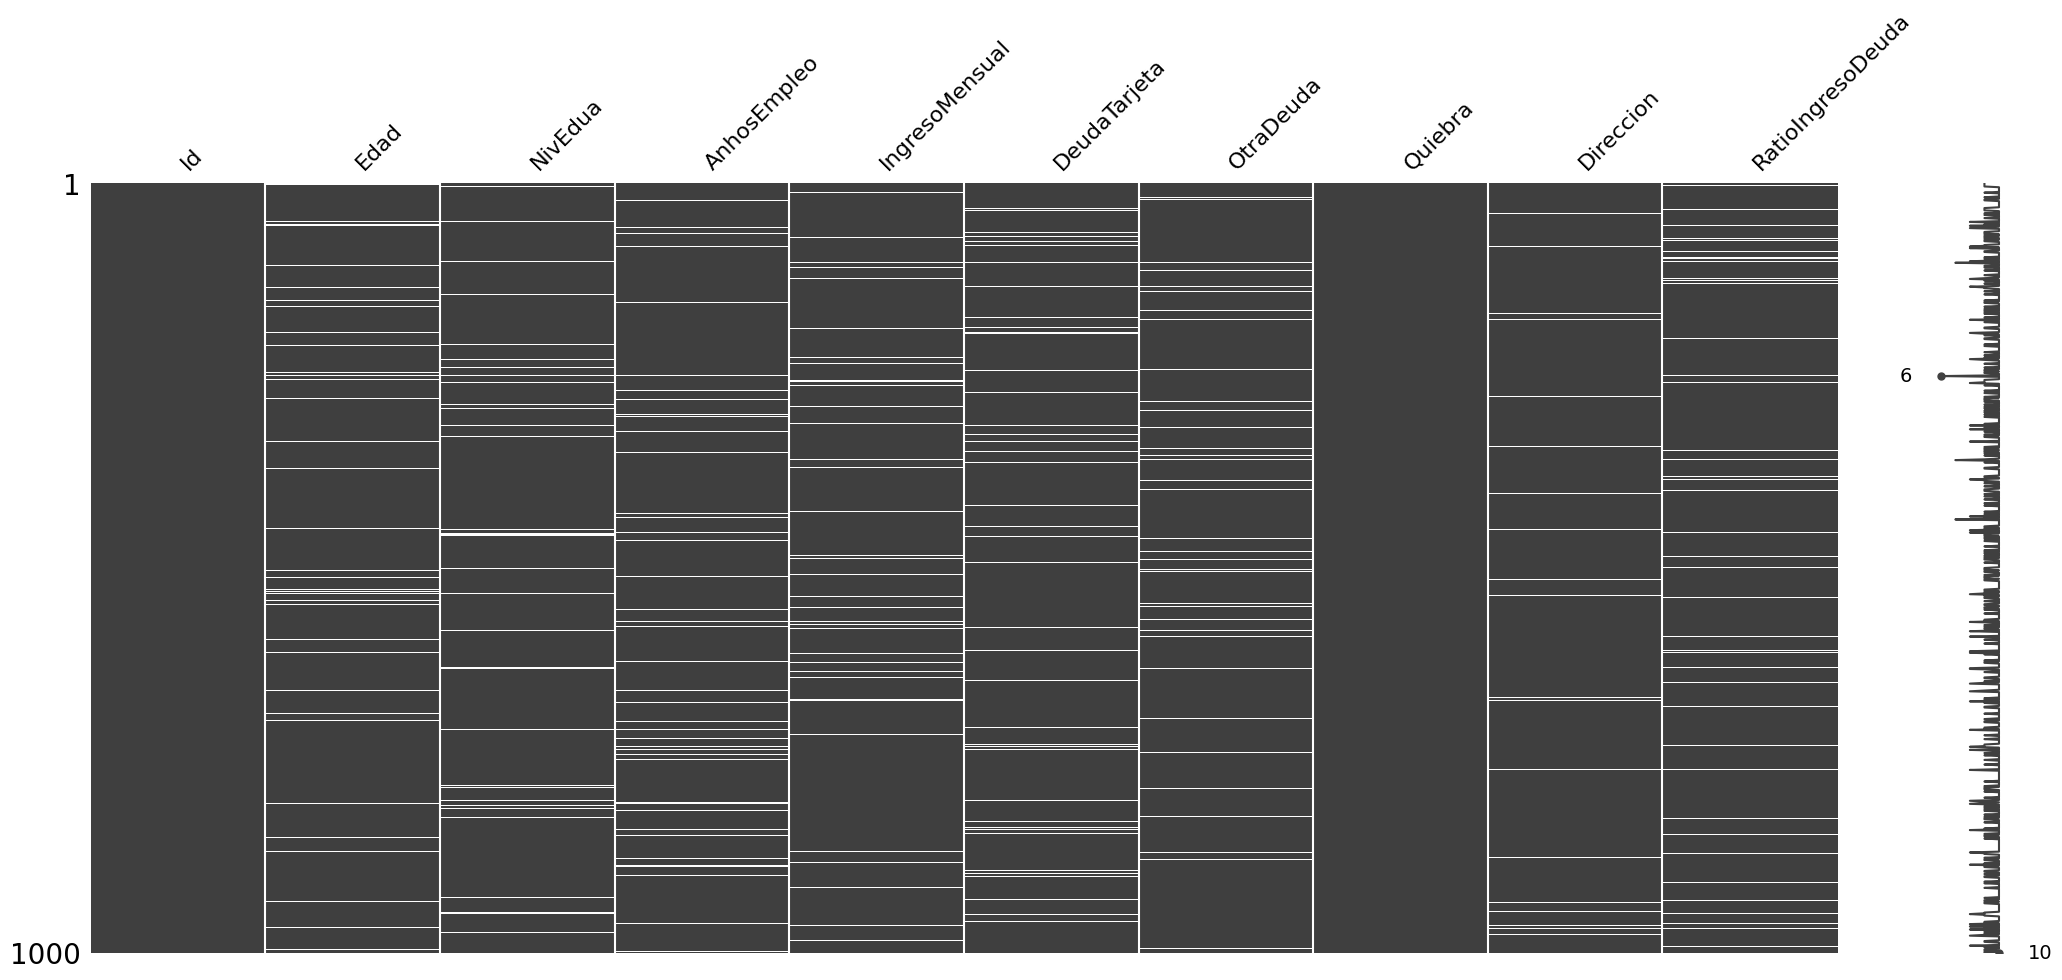

In [28]:
import missingno as msno #Importa la librería para gestionar los valores nulos
import matplotlib.pyplot as plt #Importa la librería para gráficar los resultados
msno.matrix(df) #Genera un gráfico en forma de matriz:
#- Donde cada barra vertical es una columna del DataFrame
#- Las lineas blancas muestran los valores nulos (NaN)
#- LAs lineas de color indican los valores presentes
#- Permite ver donde hay más datos nulos en el Dataset
plt.show() #Muestra el resultado


In [29]:
#Es el esquema esperado de las columnas 
# y sus tipos de datos, 
# para que el análisis sea correcto
EXPECTED_SCHEMA = { 
    "Id": "Int64",
    "Edad": "Float64",                  
    "NivEdua": "Float64",
    "AnhosEmpleo": "Float64",
    "IngresoMensual": "Float64",
    "DeudaTarjeta": "Float64",
    "OtraDeuda": "Float64",
    "Quiebra": "Int64",                
    "Direccion": "string",             
    "RatioIngresoDeuda": "Float64"
}
#Se crea una funcion para asegurar el tipo de dato deaseado, 
# recibiendo un dataframe y devolviendo el dataframe parseado
def aseguraTipoDatosDeseados(df: pd.DataFrame, schema: dict = EXPECTED_SCHEMA) -> pd.DataFrame:
    df = df.copy() 
    #crea una copia para no modificar el archivo original
    for c in df.select_dtypes(include=["bool"]).columns: 
        #Itera por cada columna booleana
        df[c] = df[c].astype("Int64") #Y las convierte e a enteros (0/1)
    for c, t in schema.items(): 
        #Recorre cada columna definida en el esquema con tu tipo esperado
        if c in df.columns: 
            #Si la columna esperada se encuentra en una columna del Dataset
            try:
                df[c] = df[c].astype(t) #Intenta convertirla al tipo de dato esperado
            except Exception: #Si ocurre un eror
                # Si no es string lo pasa a númerico, 
                # manejando errores con el coerce (si da error pone NaN)
                # Si el esperado es String lo fuerza a que sea tipo texto
                df[c] = pd.to_numeric(df[c], errors="coerce") if t != "string" else df[c].astype("string")
    return df #Devuelve el DataFrame con los tipos de datos corregidos


In [30]:
#Se crea una función para normalizar los string, recibiendo un DataFrame y devolviendo este mismo 
def normalizacionStrings(df: pd.DataFrame, cols=("Direccion",)) -> pd.DataFrame:
    df = df.copy() #crea una copia para no modificar el archivo original
    for c in cols: #Recorre las columnas indicadas en los parametros que recibe la función
        if c in df.columns:#Si la columna existe en el Dataset
            df[c] = (
                df[c].astype("string") #asegura que la columna sea tipo texto
                #reemplaza varios espacios en blanco 
                # (tabs o saltos de líneas) por un único espacio
                .str.replace(r"\s+", " ", regex=True) 
                #busca con una expresión regular todos los casos donde 
                # haya uno o más espacios en blanco consecutivos 
                # (\s+ incluye espacios, tabulaciones, saltos de línea, etc.) 
                # y los reemplaza por un único espacio " ".
                #Elimina espacios/tabs/saltos de linea al inicio y al final del texto
                .str.strip() #Por defecto elimina espacios, tabulaciones 
                #y saltos de línea en los extremos (izquierda y derecha).
                #No afecta los espacios dentro del texto.
                .str.upper() #convierte todo el texto en MAYÚSCULAS
            )
    return df #retorna el DataFrame con los textos normalizados

In [31]:
#Se crea una función para eliminar valores duplicados, recibiendo un dataframe y devolviendo este mismo sin duplicados
def eliminacionDuplicados(df: pd.DataFrame, subset=None) -> pd.DataFrame:
    df = df.copy() #crea una copia para no modificar el archivo original
    if subset is None: #Si no se declara subset
        subset = [c for c in df.columns if c != "Id"] 
        #Usa todas las columnas excepto "Id"
    #Retorna el dataframa sin los duplicados, 
    # conversando la primera fila encontrada
    return df.drop_duplicates(subset=subset, keep="first").reset_index(drop=True) 
    #Busca filas duplicadas considerando solo las columnas definidas en subset. 
    #Si encuentra duplicados, conserva la primera aparición y elimina las demás.
    #Reinicia el índice del DataFrame para que quede ordenado 
    # desde 0, 1, 2, … después de eliminar filas. 
    # El parámetro drop=True evita que el índice antiguo 
    # quede como una columna extra.

In [32]:
#Se crea una función para eliminar valores nulos, recibiendo un dataframe y devolviendo el mismosin los nulos
def eliminarNulos(df: pd.DataFrame, umbral_col: float = 0.5) -> pd.DataFrame:
    #umbral_col : float Proporción máxima de nulos permitida en una columna (0%–100%). 
    # Si una columna tiene más nulos que este valor, se elimina.
    df = df.copy() #crea una copia para no modificar el archivo original
    df = df.dropna(axis=1, thresh=int(len(df) * (1 - umbral_col))) 
    #thresh define el mínimo número de valores NO nulos requeridos para que la columna se conserve.
    df = df.dropna(axis=0) #axis 0 la eliminacion se hace por filas
    return df #Devuelve el DataFrame limpio

In [33]:
#Creamos la funcion para limpiar todo el Dataframe
def clean_clients_df(df: pd.DataFrame) -> pd.DataFrame:
    #Se llama a todas las funciones creadas en las líneas anteriores:
    df = aseguraTipoDatosDeseados(df) #Como el de parsear a datos deseados
    df = normalizacionStrings(df, cols=("Direccion",)) #El de normalizar las cadenas de texto
    df = eliminacionDuplicados(df) #La eliminacion de duplicados
    df = eliminarNulos(df) # Y la eliminacion de datos nulos
    return df #Retorna el DataFrame limpio

In [34]:
df_clean = clean_clients_df(df) #Se crea una nueva variable con el DataFrame ya limpio.

In [35]:
df_clean.shape #Vemos la nueva dimensionalidad del dataset limpio

(671, 10)

In [36]:
df_clean.dtypes #vemos los nuevos tipos de datos del dataset limpio

Id                            Int64
Edad                        Float64
NivEdua                     Float64
AnhosEmpleo                 Float64
IngresoMensual              float64
DeudaTarjeta                Float64
OtraDeuda                   Float64
Quiebra                       Int64
Direccion            string[python]
RatioIngresoDeuda           Float64
dtype: object

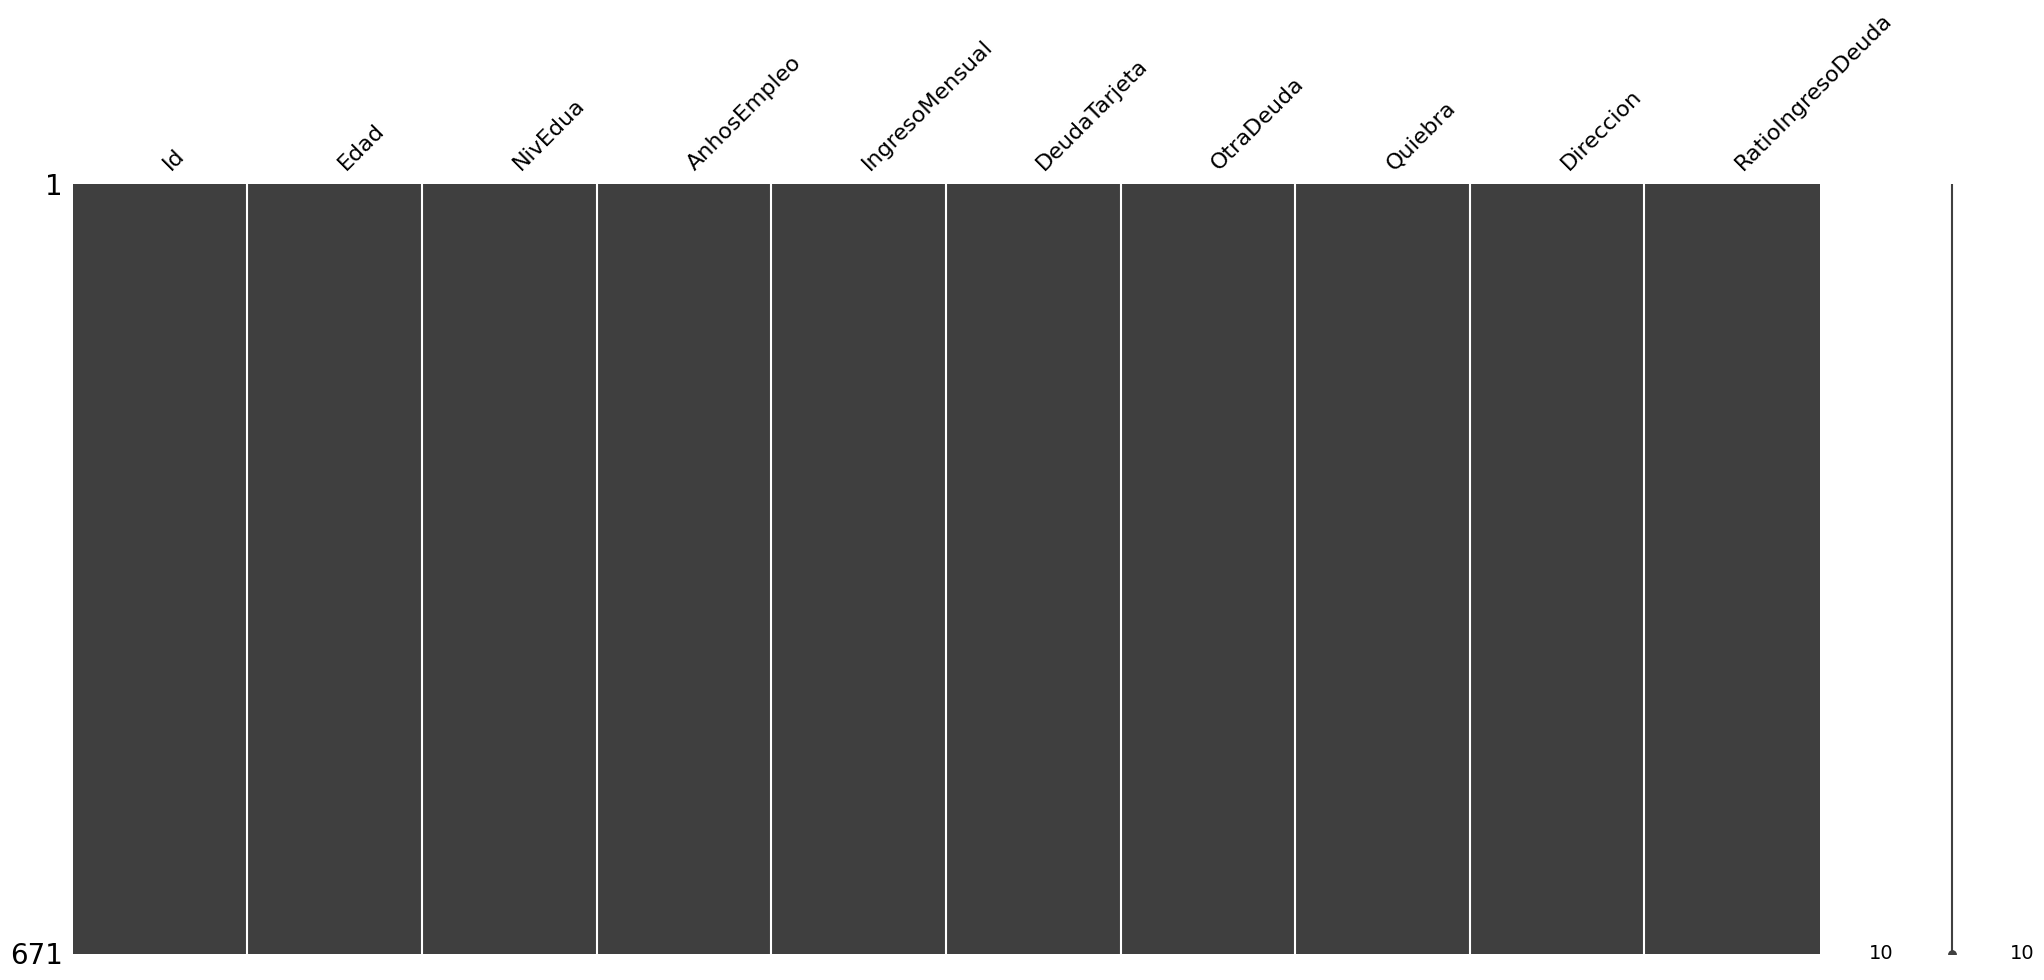

In [37]:
msno.matrix(df_clean) #Graficamos la nueva matriz para ver si quedaron datos nulos
plt.show()#y la mostramos

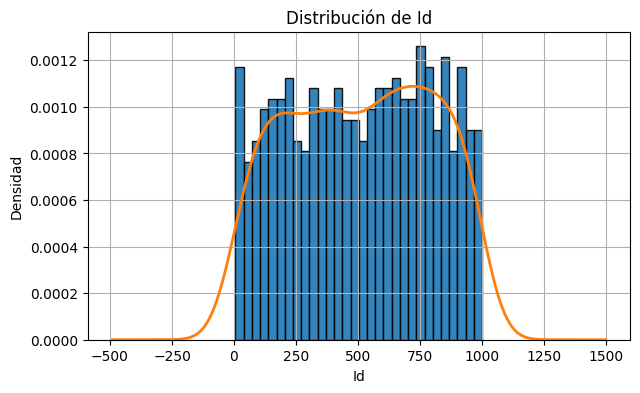

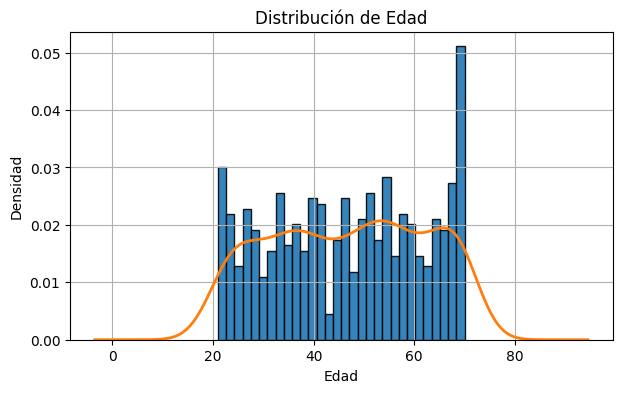

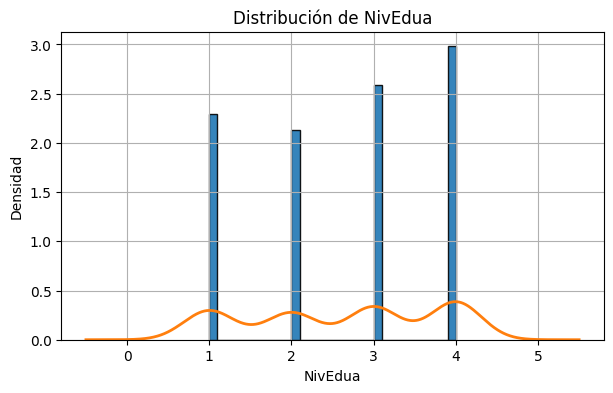

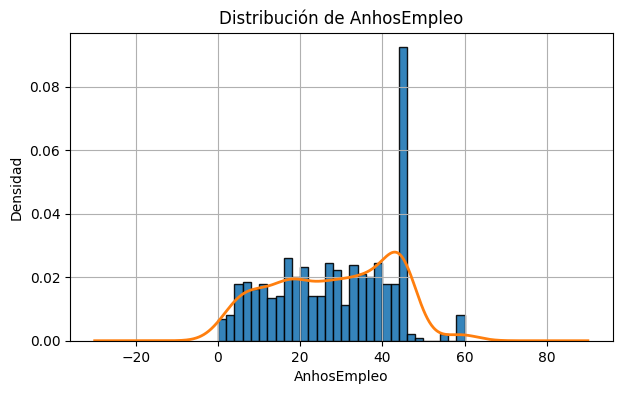

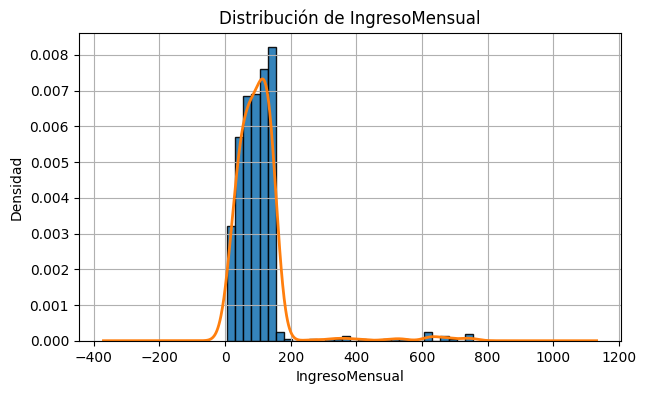

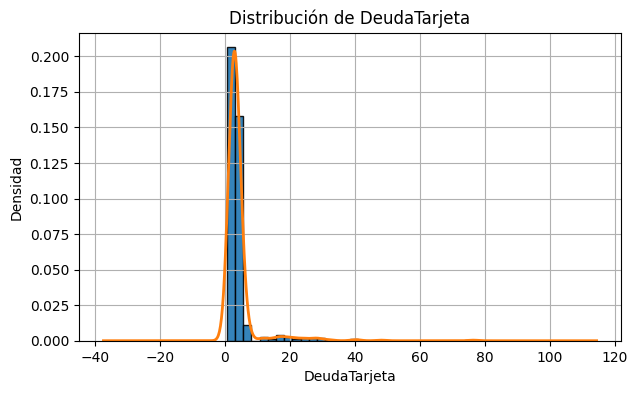

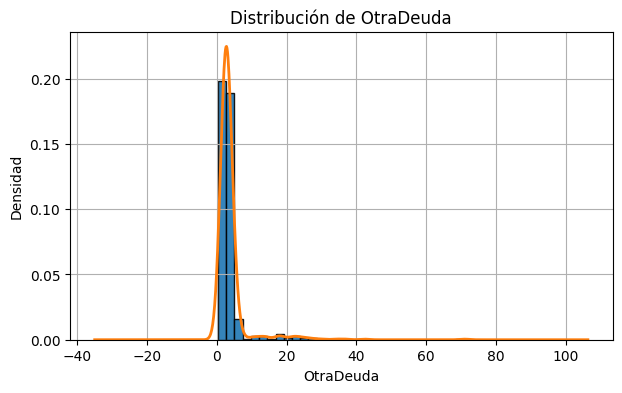

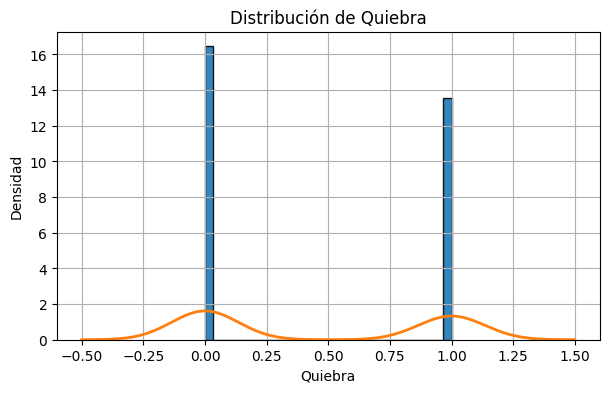

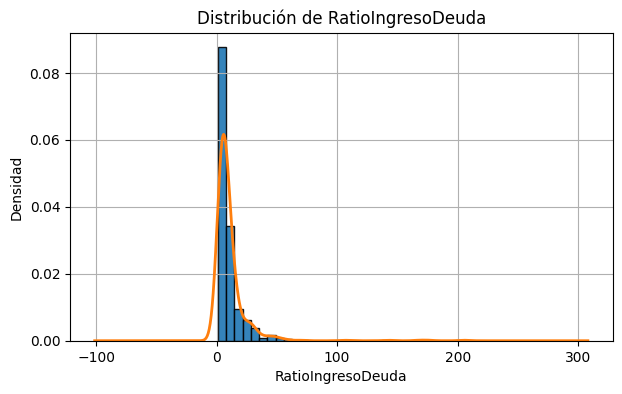

In [38]:
import matplotlib.pyplot as plt

num_cols = df_clean.select_dtypes(include=["number", "bool"]).columns.tolist()
#Seleccionamos las columnas que contengan datos númericos o booleanos del dataset limpio,
#y las devolvemos como una lista.

for col in num_cols: #Recorremos las columnas númericas/booleanas
    serie = pd.to_numeric(df_clean[col], errors="coerce").dropna()
    #Convierte la columna a números, si no se puede la convierte a NaN y despues se borra
    plt.figure(figsize=(7, 4)) #Define el tamaño del gráfico a mostrar
    #Dibuja un histograma de serie, con 30 barras, normalizando la densidad,
    # con una transpariencia de 0.6 o 60% y agregando un borde negro a las barras
    plt.hist(serie, bins=30, density=True, alpha=0.9, edgecolor="black")

    serie.plot(kind="kde", linewidth=2)
    #Dibuja la curva de densidad encima del histograma, muestra la distribucion "aproximada" de los datos
    plt.title(f"Distribución de {col}") #Agrega un titulo para cada columna
    plt.xlabel(col) #En X escribe la columna
    plt.ylabel("Densidad") #Y escribe densidad
    plt.grid(True) #Muestra una rejilla de fondo
    plt.show()#muestra el gráfico

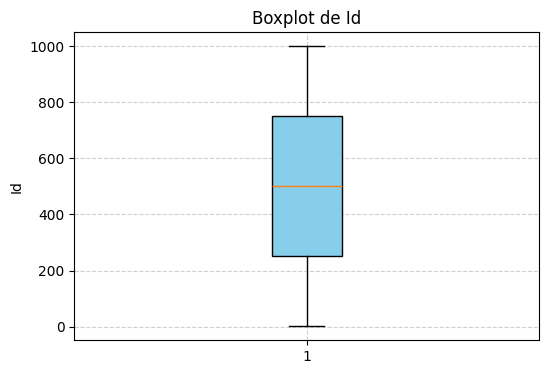

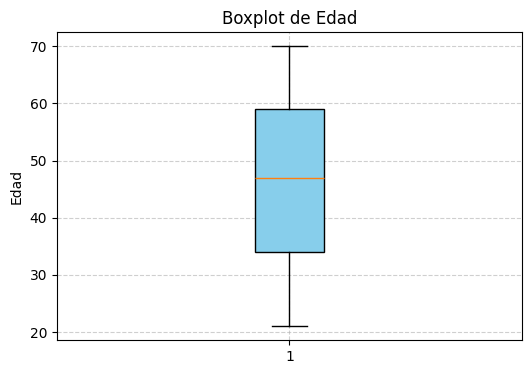

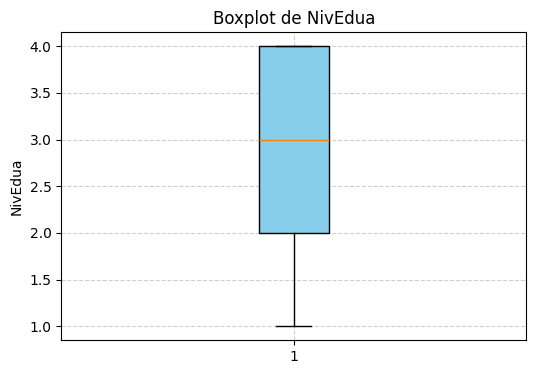

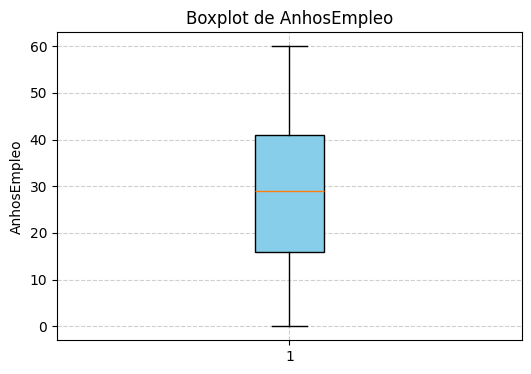

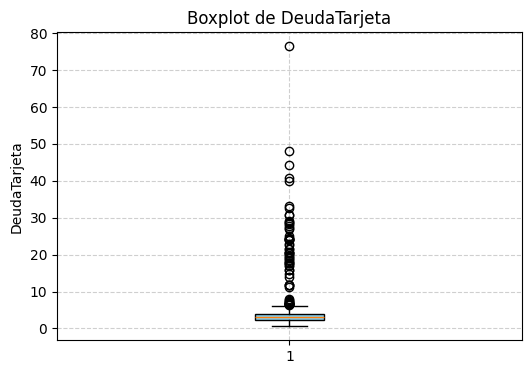

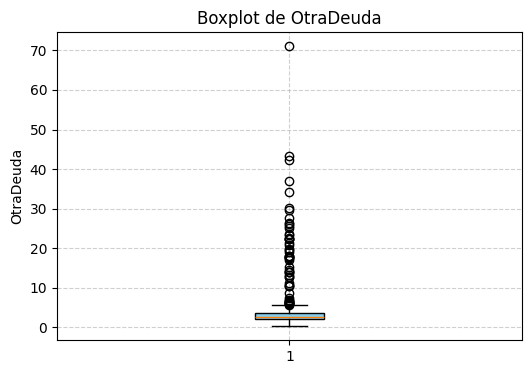

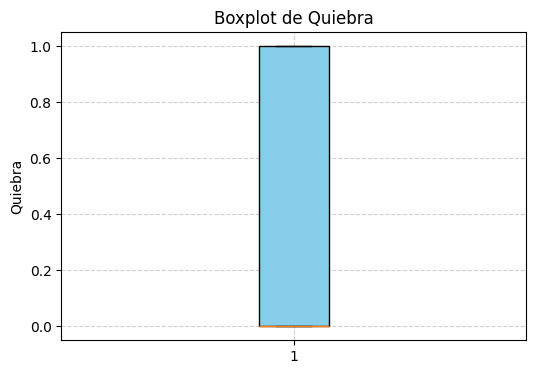

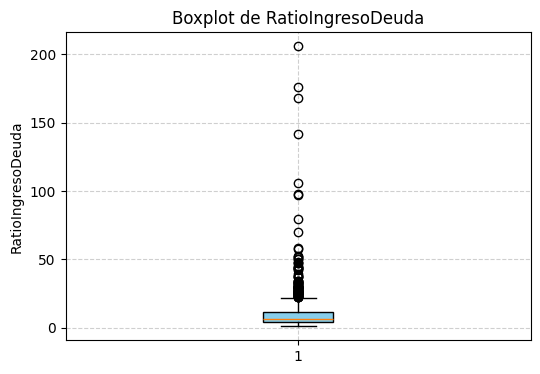

In [39]:
num_cols = df.select_dtypes(include=["number"]).columns.tolist() #selecciona las columna que tengan datos númericos
for col in num_cols:
        serie = pd.to_numeric(df[col], errors="coerce").dropna()#Los transforma a númericos y borra los NaN
        plt.figure(figsize=(6,4))
        #Dibuja un boxplot de la serie, en vertical, rellena el boxplot, y se indica el color de relleno
        plt.boxplot(serie, vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue"))
        plt.title(f"Boxplot de {col}")
        plt.ylabel(col)
        plt.grid(True, linestyle="--", alpha=0.6) #Es el fondo del gráfico
        plt.show()

In [40]:
#Eliminar los outliers (Valores atípicos), recibiendo un datagrame, 
# las columnas en las que quiere eliminar los outliers y el factor
#que define que tan lejado está para considerarse un outlier
def eliminaOutliers(df: pd.DataFrame, cols=None, k: float = 1) -> pd.DataFrame:
    df_clean = df.copy() #crea una copia para no modificar el archivo original
    if cols is None: #Si no se declara las columnas en la que se quiere trabajar
        cols = df_clean.select_dtypes(include="number").columns.tolist()#Se ocuparán todas las númericas
    for col in cols: #Itera las columnas
        q1 = df_clean[col].quantile(0.25) #Saca el primer cuartil
        q3 = df_clean[col].quantile(0.75) #Saca el tercer cuartil
        iqr = q3 - q1 #Calcula el rango intercuartílico, midiendo la dispersión central de los datos
        lower = q1 - k * iqr #Declara el limite minimo inferior
        upper = q3 + k * iqr #Declara el limite maximo superior
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)] 
        #Obtiene los datos que se encuentran dentro de los limites
    return df_clean #retorna el dataset limpio de outliers

In [41]:
df_clean_sin_outliers = eliminaOutliers(df_clean) #Crea una nueva variable con los datos limpios, pero sin outliers

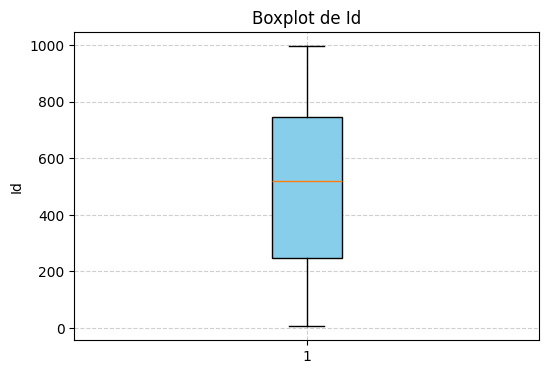

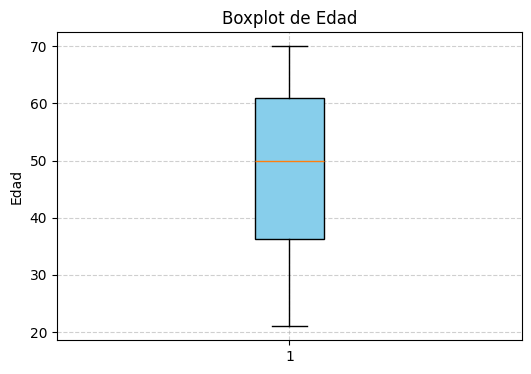

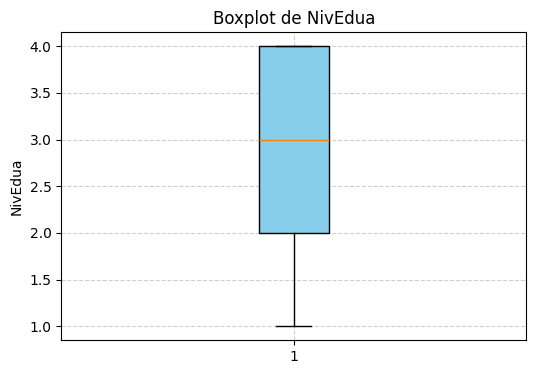

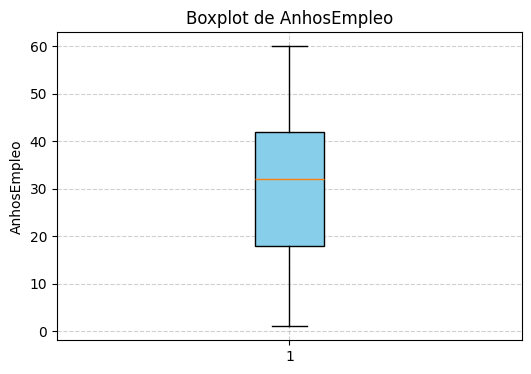

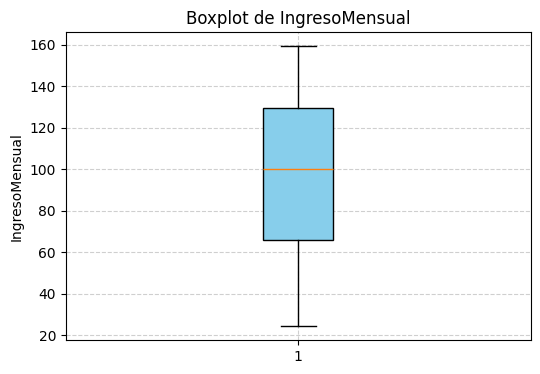

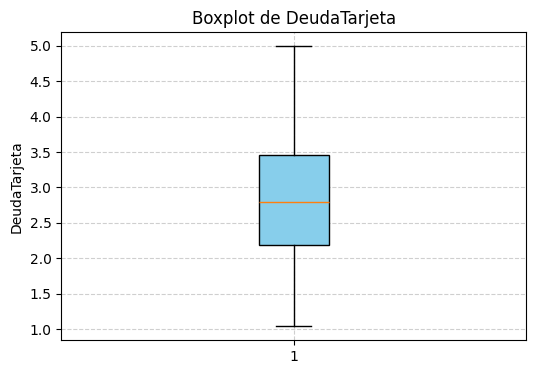

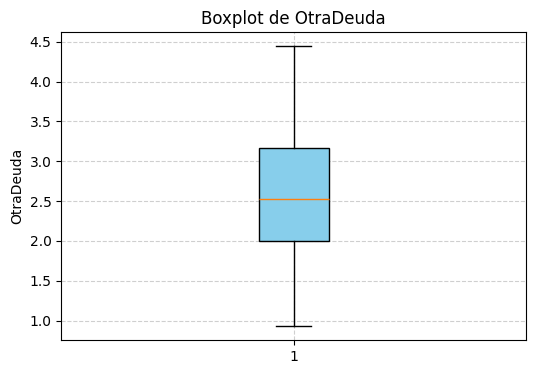

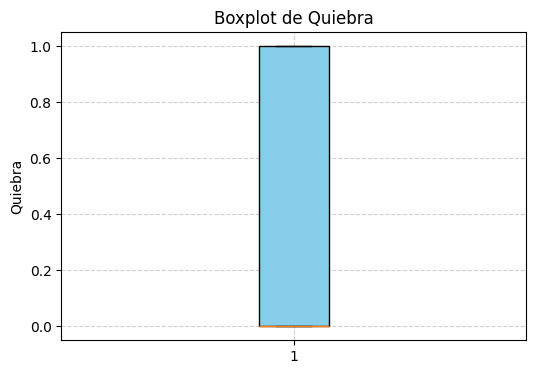

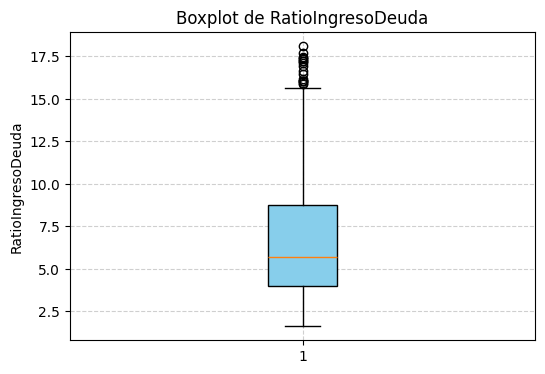

In [42]:
#Lo mismo de antes
num_cols = df_clean_sin_outliers.select_dtypes(include=["number"]).columns.tolist()
for col in num_cols:
        serie = pd.to_numeric(df_clean_sin_outliers[col], errors="coerce").dropna()
        plt.figure(figsize=(6,4))
        plt.boxplot(serie, vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue"))
        plt.title(f"Boxplot de {col}")
        plt.ylabel(col)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.show()

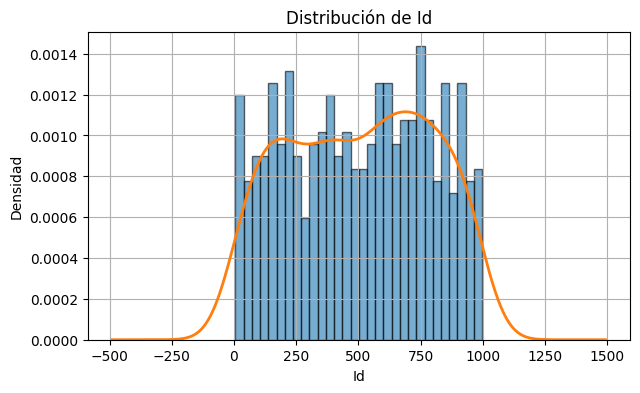

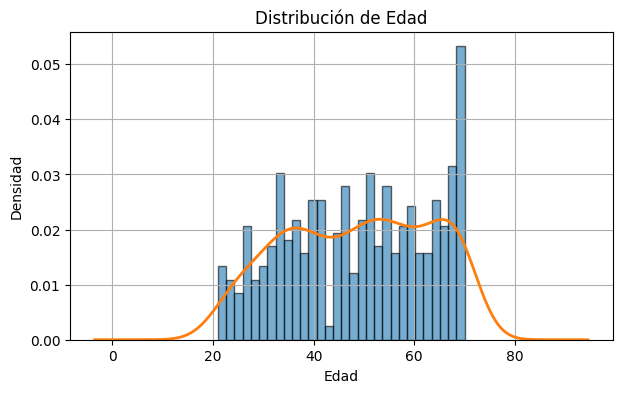

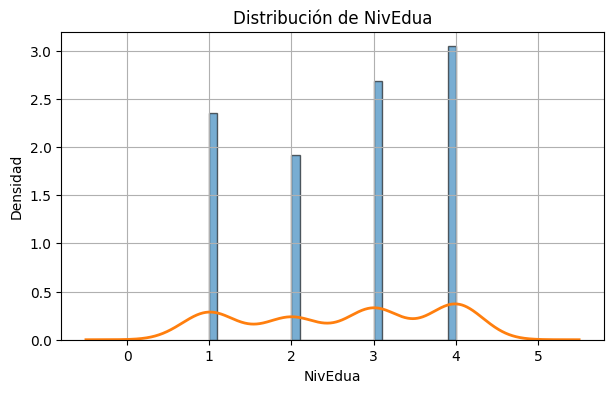

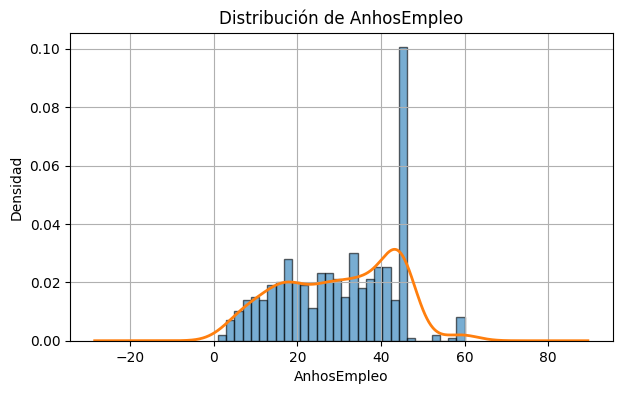

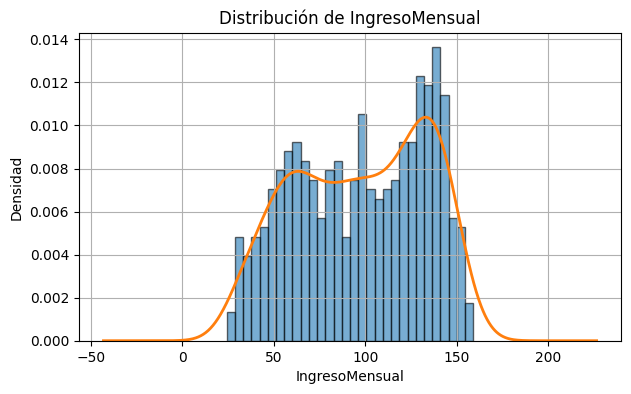

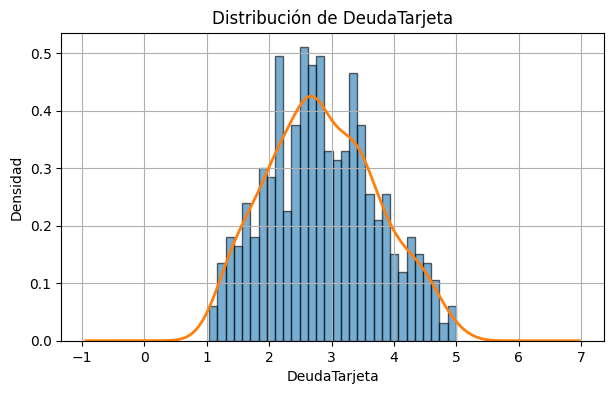

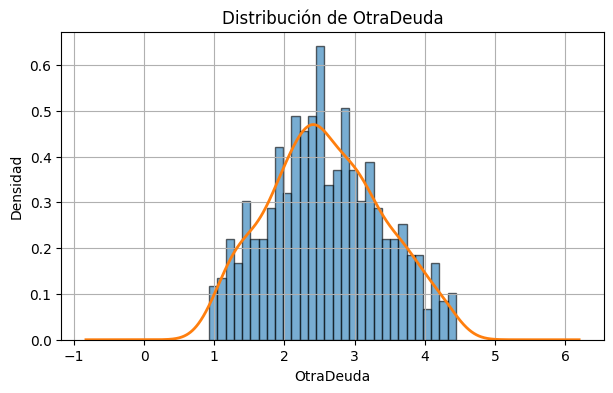

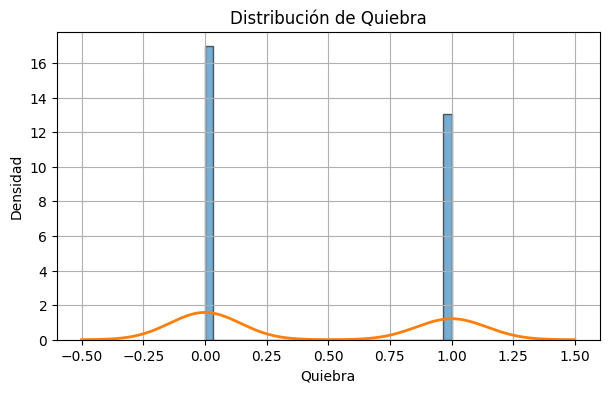

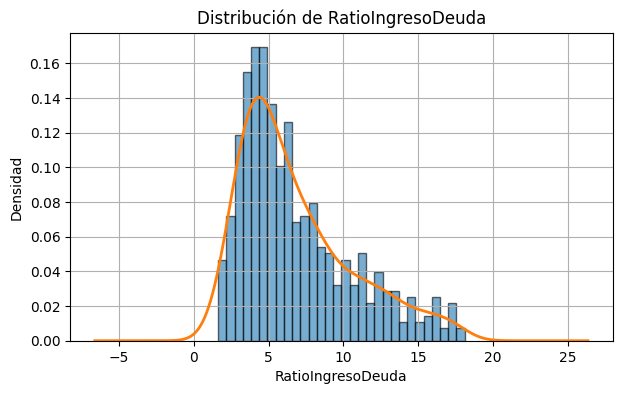

In [43]:
#Lo mismo de antes
num_cols = df_clean_sin_outliers.select_dtypes(include=["number", "bool"]).columns.tolist()

for col in num_cols:
    serie = pd.to_numeric(df_clean_sin_outliers[col], errors="coerce").dropna()
    plt.figure(figsize=(7, 4))
    plt.hist(serie, bins=30, density=True, alpha=0.6, edgecolor="black")
    serie.plot(kind="kde", linewidth=2)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Densidad")
    plt.grid(True)
    plt.show()

In [44]:
df_clean_sin_outliers.shape #Muestra la nueva dimensionalidad de los datos limpios y sin los outliers

(506, 10)

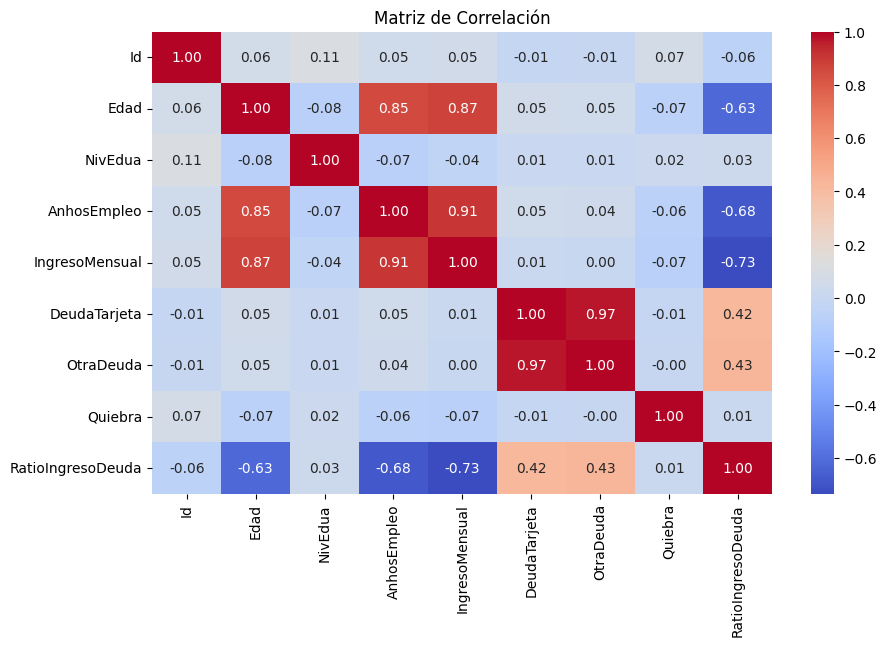

In [45]:
import seaborn as sns #Librería para gráficos de matriz de correlación
num_df =  df_clean_sin_outliers.select_dtypes(include="number") #Obtiene los datos númericos
corr = num_df.corr() #Calcula la matriz de correlación de las columnas númericas
#Cada valor es cuán relacionadas están las columnas
plt.figure(figsize=(10, 6)) 
#Dibuja la matriz de correlación con un mapa de calor, mostrando los valores en cada celda, con 2 decimales, 
#usando paleta de colores (azul -> rojo), mostrando la barra de colores al lado.
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlación") #Agrega un titulo
plt.show() # la dibuja

In [46]:
#Bloque de preprocesamiento de datos y reduccion de dimensionalidad usando PCA
from sklearn.preprocessing import StandardScaler #Estandarizamos los datos, restando la media y dividiendo por la desviación estándar
#(media = 0, desviación = 1)
from sklearn.decomposition import PCA #Reduce la cantidad de variables manteniendo la mayor varianza posible
import numpy as np #Operacion númericas

num_cols = df_clean_sin_outliers.select_dtypes(include="number").columns.tolist() #Selecciona solo columnas númericas y 
#las devuelve en listas
num_cols = [c for c in num_cols if c not in ["Id", "Quiebra"]] #Excluye Id y Quiebra

X = df_clean_sin_outliers[num_cols].copy() #Creamos una copia de las columnas númericas para no sobreescribir por encima
y = df_clean_sin_outliers["Quiebra"].copy() #Creamos una copia de la variable objetivo para no afectar al DF original.

y = pd.to_numeric(y, errors="coerce") #Asegura que sea númerico, sino lo vuelve NaN
y = y.astype(int) #Fuerza que sea tipo entero

df_xy = X.join(y.rename("Quiebra")) #Une las 2 variables y asegura que la columna y se llame "Quiebra" al unirlas
df_xy = df_xy.dropna(axis=0) #Elimina las filas que tengan algún valor nulo

X = df_xy.drop(columns=["Quiebra"]) #Vuelve a separar X e Y, donde X queda con variables explicativas
y = df_xy["Quiebra"] # e Y con la variable objetivo

scaler = StandardScaler() #Crea un objeto StandardScaler, este sabe estandarizar columnas
X_scaled = scaler.fit_transform(X) #Calcula la media y desviacion estándar de cada columna en X y aplica la estandarizacion
#X_scaled = [(X- media)/desviación] ; X_scales tiene el mismo tamaño que X, pero todas las columnas tiene media 0 y desviación 1
#Es importante para PCA porque este depende la varianza para decidir que direcciones son más importantes

#Decide cuántos componenetes principales calcular, si hay más de 6 columnas, usa 6; sino ocupa el número de columnas
n_comp = min(6, X_scaled.shape[1]) 
#Crea un objeto PCA con el número de componenetes de n_comp
pca = PCA(n_components=n_comp)
#Calcula las componentes principales, o sea, las nuevas combinaciones de variables donde se encuentra la mayor varianza y transforma las 
#nuevas dimensinoes
X_pca = pca.fit_transform(X_scaled) #Resultado -> matriz con las columnas nuevas, donde cada columna = un componente principal

#Es un arreglo que dice *qué proporción de la varianza total* explica cada comp principal y lo redondea a 4 decimales
print("Varianza por componente:", np.round(pca.explained_variance_ratio_, 4))
#Lo mismo de arriba, pero este habla de la suma acumulada de lavarianza, indicando cuanta informacion total se captura si usas las
#primeras n componentes
print("Varianza acumulada:", np.round(pca.explained_variance_ratio_.cumsum(), 4))

Varianza por componente: [0.4837 0.3051 0.1424 0.0334 0.0197 0.0116]
Varianza acumulada: [0.4837 0.7888 0.9312 0.9645 0.9842 0.9958]


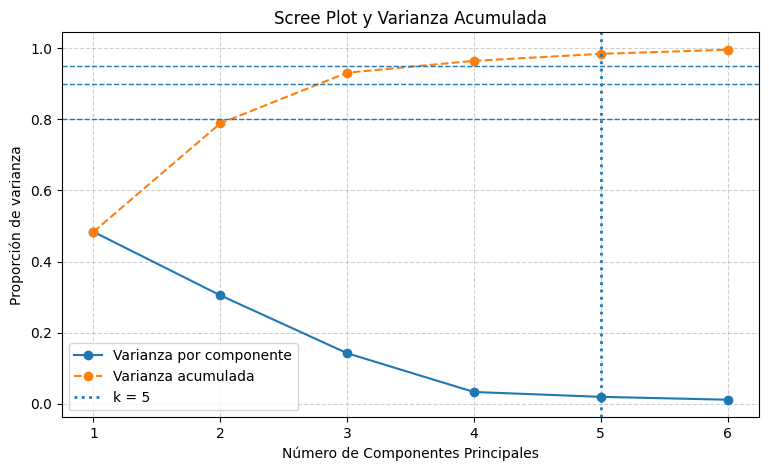

Varianza por componente: [0.4837 0.3051 0.1424 0.0334 0.0197 0.0116]
Varianza acumulada: [0.4837 0.7888 0.9312 0.9645 0.9842 0.9958]
Con k = 5, varianza acumulada = 0.9842


In [47]:
import numpy as np
import matplotlib.pyplot as plt

varianza = pca.explained_variance_ratio_ #proporcion de varianza que explica cada componente principal
var_acum = varianza.cumsum() #varianza acumulada (suma progresiva de la varianza)
ks = np.arange(1, len(varianza) + 1) #Es el numero de cada componente en el eje x del grafico

k_elegido = 5 if len(varianza) >= 5 else len(varianza) #Si hay >= 5 componentes usa 5, sino al número total de componentes disponibles
#Se usa para marcar en el gráfico una línea vertical, como referencia de "hasta que componente estamos considerando" como importante

# ----- Gráfico 1: Scree Plot (varianza individual y acumulada) -----
plt.figure(figsize=(9,5))
plt.plot(ks, varianza, marker="o", label="Varianza por componente") #Se gráfica la varianza individual de cada componente
plt.plot(ks, var_acum, marker="o", linestyle="--", label="Varianza acumulada") #Se grafica la varianza acumulada con lineas puntuadas
plt.axvline(k_elegido, linestyle=":", linewidth=2, label=f"k = {k_elegido}") #Linea verical que marca k_elegido
plt.axhline(0.80, linestyle="--", linewidth=1) #Lineas horizontales para referencia visual de % de varianza acumulada
plt.axhline(0.90, linestyle="--", linewidth=1) #==
plt.axhline(0.95, linestyle="--", linewidth=1) #==
plt.xticks(ks) #Pone los números exactos de los componentes en el eje X
plt.xlabel("Número de Componentes Principales") #Título eje X
plt.ylabel("Proporción de varianza") #Título eje Y
plt.title("Scree Plot y Varianza Acumulada") #Título gráfico
plt.legend() #Muestra la caja que identifican las lineas
plt.grid(True, linestyle="--", alpha=0.6) #Muestra una cuadricula al fondo
plt.show() #Muestra el grafico

# ----- Texto de apoyo para tus estudiantes -----
print("Varianza por componente:", np.round(varianza, 4))
print("Varianza acumulada:", np.round(var_acum, 4))
print(f"Con k = {k_elegido}, varianza acumulada = {var_acum[k_elegido-1]:.4f}")


In [48]:
#Es la matriz resultante de PCA, con los componentes principales ya calculados.
#Convierte esta matriz en un dataframe de pandas , creando una lista de nombres para la columnas,
#donde cada columna es un comp principal
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(6)])
#Selecciona los valores de "Quiebra" correspondientes a los índices de num_df(las filas que se usaron para PCA)
#Los convierte en un array de numpy para asginarlo a la columna nueva
df_pca["Quiebra"] = df_clean_sin_outliers.loc[num_df.index, "Quiebra"].values #Se agrega "Quiebra" al DataFrame df_pca

In [49]:
print(df_pca.shape) #Se imprime la dimensionalidad del nuevo DataFrame
df_pca.head() #Se imprimen las primeras 5 filas

(506, 7)


,PC1,PC2,PC3,PC4,PC5,PC6,Quiebra
0,1.998401,-1.859170,1.259282,0.058080,0.218551,0.229795,0
1,-1.860984,1.898759,-1.496619,-0.146039,0.196538,-0.122493,0
2,-2.732434,-1.407914,0.170748,-0.053885,0.075719,0.019061,0
3,-2.178015,-0.857394,1.067155,0.178264,-0.200808,-0.155422,1
4,0.793332,-0.612156,1.222565,-0.131676,-0.028991,-0.038088,0


In [50]:
from sklearn.model_selection import train_test_split #Divide los datos en entrenamiento y prueba
from sklearn.neural_network import MLPClassifier #Clasificador de red neuronal artificial de tipo Perceptrón Multicapa 
#(multi layer perceptron)
from sklearn.metrics import classification_report, confusion_matrix #Métricas para evaluar el rendimiento del modelo
#classification_report -> imprime metricas por clase (precision, recall, f1-score, support)
#confusion_matrix -> crea la matriz de confusión (tp, fp, tn, fn) para evaluar errores
# ========= 5) Split (estratificado solo si hay al menos 2 por clase) =========
#si el minimo es mayor o igual a 2, quiere decir que todas las clases tienen al menos 2 ejemplos
# (sino, no se puede estratificar bien)
#Dependiendo de la cantidad del minimo, se decide si aplicar estratificación o no,
strat = y if y.value_counts().min() >= 2 else None
#Divide X e Y en entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(
    #el 20% de los datos va para prueba y el 80% para entrenamiento
    X, y, test_size=0.2, stratify=y #Garantiza que en train y test exista la misma proporcion de clases que en dataset 
    #original(util si hay desbalance)
)

# ========= 6) MLPClassifier =========
mlp = MLPClassifier( #Armamos la red neuronal
    hidden_layer_sizes=(32, 16), #Define la arquitectura de la red neuronal: 2 capas ocultas, 
    #la primera con 32 neuronas y la segunda con 16
    activation="relu", #La funcion de activacion en las neuronas es ReLU (Rectified Linear Unit),
    #comun pq acelera y estabiliza el aprendizaje
    solver="adam", #Optimizador usado para ajustar los pesos de la red. Es una variante de gradiente
    #descendente muy popular
    max_iter=500, #número maximo de iteraciones (ciclos de entrenamiento)
    random_state=42 #fija la semilla aleatoria para que los resultados sean reproducibles
)
mlp.fit(X_train, y_train) #Aqui es aprende la RN .X_train variables de entrada (edad, ingreso, deuda, etc), 
#Y_train equiquetas verdaderas (0= no quebró, 1= quebró)

y_pred = mlp.predict(X_test) #Aplica lo que aprendió y da su "respuesta" para los nuevos datos
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4)) #Genera informe de desempeño del modelo, 
#comparando lo real con lo predicho
#Muestra (precision, recall, f1-score, support)
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))#Muestra donde se equivocó el modelo
#ej [[n veces predijo 0 y era 0; n veces predijo 1 pero era 0]
#    [n veces predijo 0 pero era 1: n veces predijo 1 y era 1]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.5714    0.9655    0.7179        58
           1     0.5000    0.0455    0.0833        44

    accuracy                         0.5686       102
   macro avg     0.5357    0.5055    0.4006       102
weighted avg     0.5406    0.5686    0.4442       102

Matriz de confusión:
[[56  2]
 [42  2]]


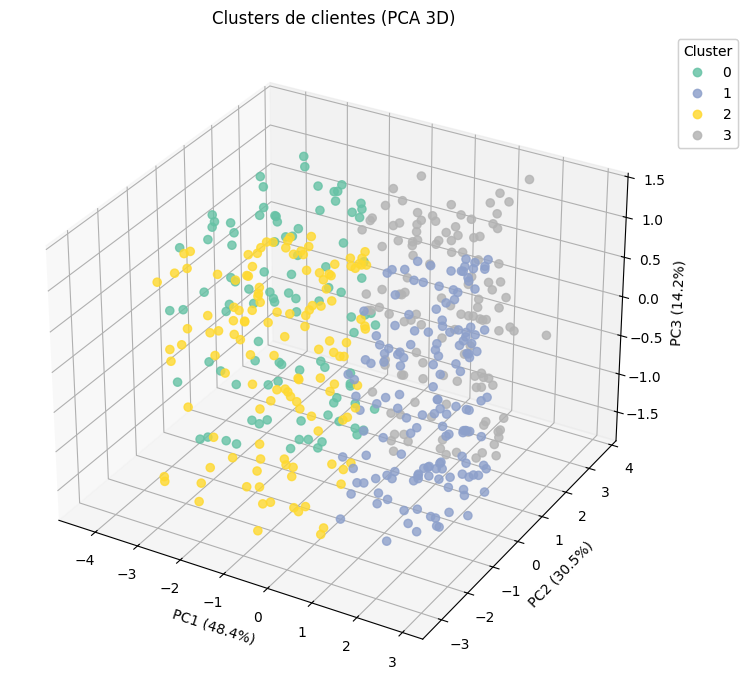

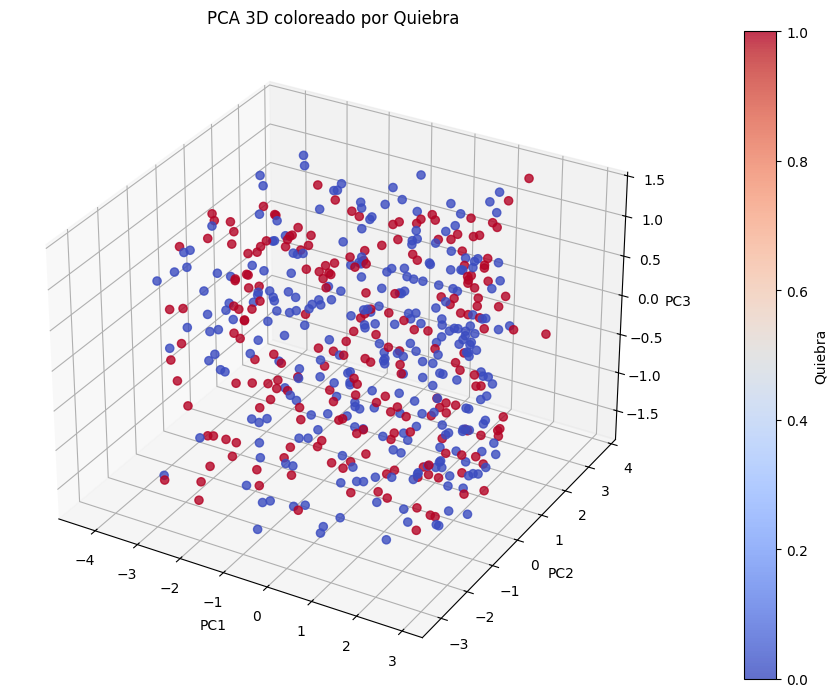

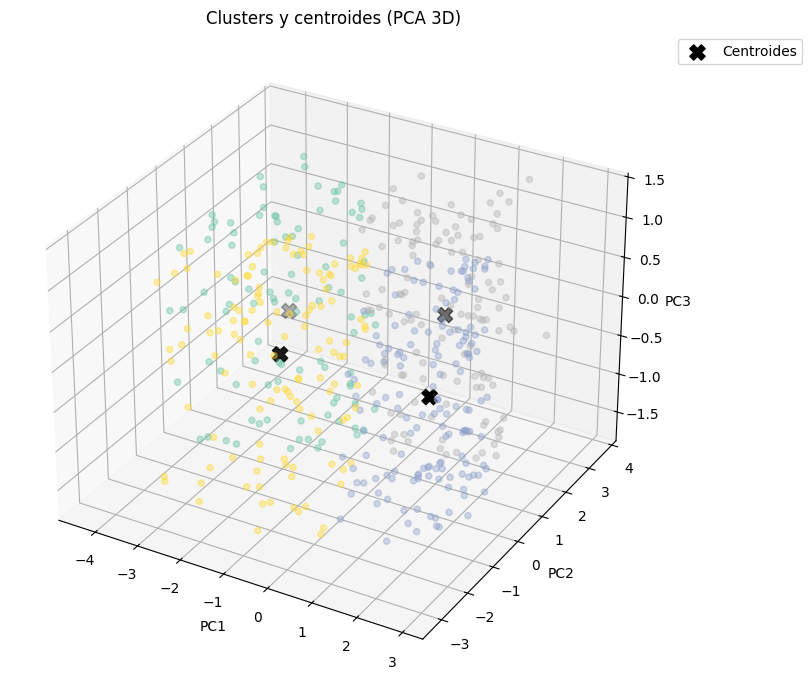

In [51]:
import pandas as pd #manejo de datos en Dataframes
from sklearn.preprocessing import StandardScaler #normaliza variables que tengan media 0 y desviacion 1
from sklearn.decomposition import PCA #reduce dimensionalidad
from sklearn.cluster import KMeans #algoritmo de cluistering, agrupa los datos en grupos similares
import matplotlib.pyplot as plt #Graficos 2D
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (necesario para 3D)

# === Preparación de datos (igual a tu flujo) ===
features = df_clean_sin_outliers.drop(columns=["Id", "Quiebra", "Direccion"], errors="ignore")#eliminamos columnas no númericas
#Reemplaza los valores nulos por la media de cada columna
X = features.select_dtypes(include="number").fillna(features.select_dtypes(include="number").mean())

scaler = StandardScaler() #Transforma cada columna para que tenga media 0 y desviación estándar 1
X_scaled = scaler.fit_transform(X)#Calcula la media y desviacion de cada columna y aplica la transformacion a los datos

# === PCA a 3D para visualización ===
pca = PCA(n_components=3)#Genera 3 nuevas variables llamadas componentes principales que capturan 
#la mayor parte de la varianza en los datos
X_pca3 = pca.fit_transform(X_scaled)#fit encuentra las direcciones de maxima varianza en sus datos
#transofrm proyecto los datos originales en esas direcciones

# === Clustering (k=4 como tu ejemplo) ===
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) #Queremos 4 grupos, 
#fija la semilla en aleatorio para obtener los mismos clusters
#el algoritmo prueba 10 inicializaciones distintas y elige la mejor
labels = kmeans.fit_predict(X_scaled) #fit -> encuentra los centroides de cada cluster
#y predict asigna a cada punto el clusters más cercano
df_clean_sin_outliers["Cluster"] = labels #guardamos esas etiquetas en una nueva columna 
#para despues analizarlas o graficarlas

# === Gráfico 3D ===
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection="3d") #Crea el grafico 3D

scatter = ax.scatter(
    X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2],#Dibuja a cada cliente como un punto en el espacio de las 3 PC
    c=labels, cmap="Set2", s=35, alpha=0.8 #c indica a que clusted pertenece cada punto, cmap es la paleta de colores
    #s es el tamaño de los puntos y alpha es la transpariencia para que se vean mejor los puntos
)

ax.set_title("Clusters de clientes (PCA 3D)")#Titulo del grafico 3D
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
#Muestra qué porcentaje de la varianza explica cada componente
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
#Para saber cuanto representan las PC en la informacion total
ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")

# Leyenda simple con los clusters
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster", loc="upper left", bbox_to_anchor=(1.02, 1))
#Muestra la leyenda para identificar cada cluster por color
ax.add_artist(legend1)

plt.tight_layout()#reorganiza todo para que se vea ordenado y no se corte
plt.show()#lo muestra


# Colorear por Quiebra (0/1) en lugar de cluster:
if "Quiebra" in df_clean_sin_outliers.columns:#Si se encuentra quiebra en el df limpio sin ouitliers
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111, projection="3d")
    q = df_clean_sin_outliers["Quiebra"].values #contiene valores de quiebra (0 o 1) para cada cliente
    #scatter dibuja los puntos usando PC1,2y3, c es el color que indica si el cliente quebró, 
    # cmap colores con contrastre 0 NQuebró 1 Quebro
    sc = ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2], c=q, cmap="coolwarm", s=35, alpha=0.8)
    ax.set_title("PCA 3D coloreado por Quiebra")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
    cb = plt.colorbar(sc, ax=ax, pad=0.1); cb.set_label("Quiebra") #Añade una barra color que explica que color corresponde 
    #a cada valor de Quiebra
    plt.tight_layout(); plt.show()

# Centroides del KMeans en el espacio PCA (proyectados)
centroids = pca.transform(kmeans.cluster_centers_)#Devuelve las coordenadas de los centroides;
#proyectar centroides escalados a 3D
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection="3d")
#Dibuja a todos los clientes con traspariencia de un 40%
ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2], c=labels, cmap="Set2", s=20, alpha=0.4)
#Dubja los centroides en negro, con un tamaño mayor y un marcador X
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], c="black", s=120, marker="X", label="Centroides")
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
ax.set_title("Clusters y centroides (PCA 3D)")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
plt.tight_layout(); plt.show()


Mejores params: {'clf__ccp_alpha': 0.0, 'clf__max_depth': None, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 2}

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.5714    0.4138    0.4800        58
           1     0.4333    0.5909    0.5000        44

    accuracy                         0.4902       102
   macro avg     0.5024    0.5024    0.4900       102
weighted avg     0.5119    0.4902    0.4886       102

Matriz de confusión:
 [[24 34]
 [18 26]]
ROC-AUC: 0.5195924764890283

Top 20 importancias:
                feature  importance
5            OtraDeuda    0.321384
6    RatioIngresoDeuda    0.241621
4         DeudaTarjeta    0.193135
3       IngresoMensual    0.168697
2          AnhosEmpleo    0.049534
7              Cluster    0.025629
8     Direccion_NBA006    0.000000
9     Direccion_NBA007    0.000000
10    Direccion_NBA008    0.000000
11    Direccion_NBA009    0.000000
380   Direccion_NBA905    0.000000
27    Direcc

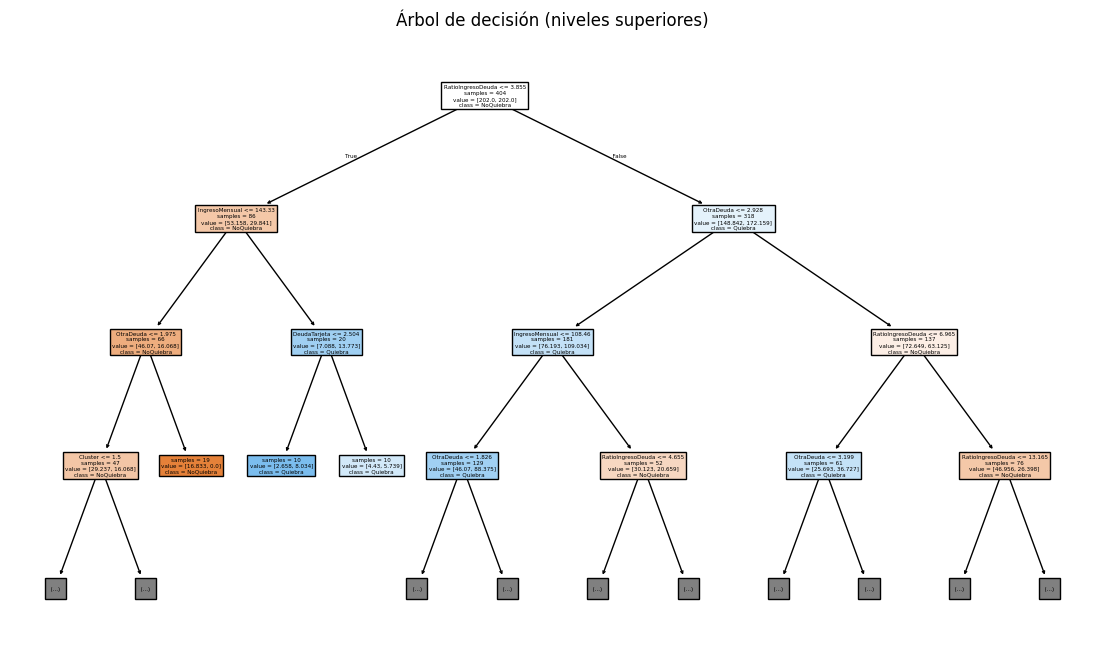

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV 
#Grid -> busca los mejores hiperparametros del modelo con validacion cruzada
from sklearn.impute import SimpleImputer
#Para rellenar valores nulos en columnas : strategy"median" mediana o "most_frequent" moda
from sklearn.compose import ColumnTransformer 
#Aplica diferentes transformaciones a diferentes columnas del DF
#Ej columnas numericas -> imputar mediana; columnas categoricas -> imputar moda y hjacer OneHotEnconding
from sklearn.preprocessing import OneHotEncoder #Convierte columnas categoricas en variables binarias 
from sklearn.pipeline import Pipeline 
#permite encadenar pasos: preprocesamiento + modelo (imputar nulos, codigicar, entrenar arbol de d)
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
#roc-> metrica que indica la calidad del modelo
from sklearn.tree import DecisionTreeClassifier, plot_tree 
#modelo del arbol de desicion; dibuja el arbol para interpretacion visual
import matplotlib.pyplot as plt
import numpy as np

y = df_clean_sin_outliers["Quiebra"].astype(int) #Variable objetivo: si el cliente quebró o no
X = df_clean_sin_outliers.drop(columns=["Quiebra", "Id"], errors="ignore")#eliminamos quiebra e ID

# 3) Columnas numéricas y categóricas (Dirección es categórica)
num_cols = X.select_dtypes(include="number").columns.tolist() #Seleccionamos las columnas numericas
cat_cols = X.select_dtypes(exclude="number").columns.tolist() #Seleccionamos las columnas no numericas

# 4) Preprocesamiento
num_pipe = Pipeline([#encadena pasos (aunque solo hay uno en este caso)
    ("imputer", SimpleImputer(strategy="median")), 
    #Reemplaza valores nulos con la mediana de cada columna
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")), 
    #Rellena valores nulos con la moda de cada columna
    ("ohe", OneHotEncoder(handle_unknown="ignore")) 
    #convierte categorias en columnas binarias (0 o 1),
    #evita errores si aparece una categoria nuevo en los datos de prueba
])
pre = ColumnTransformer([
    ("num", num_pipe, num_cols), 
    #aplica la mediana a los datos nulos que se encuentran en num_cols
    ("cat", cat_pipe, cat_cols) 
    #aplica la moda + oOneHotEnconder a los datos nulos que se encuentran en cat_cols
])

# 5) Modelo (árbol). class_weight="balanced" ayuda con desbalance.
clf = DecisionTreeClassifier(random_state=42, class_weight="balanced") 
#arbol de decision para clasificar clientes segun quiebra
#random_state -> asegura reproducibilidad

pipe = Pipeline([
    ("pre", pre), #entrena el arbol de desicion con los datos ya transformados
    ("clf", clf) #entrena el arbol de desicion con los datos ya transformados
])

# 6) Train/Test split estratificado (si hay >=2 por clase)
strat = y if y.value_counts().min() >= 2 else None #Si tiene minimo 2 ejemplos, 
#asegura que la proporcion de clases esten en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    #20% para prueba y 80% entrenamiento, reproducibilidad, 
    # mantiene proporcion de clases en ambos conjuntos
    X, y, test_size=0.2, random_state=42, stratify=strat
)

# 7) Búsqueda de hiperparámetros (rápida)
param_grid = { #Lista de valores que queremos probar para los parametros del arbol
    "clf__max_depth": [3, 5, 7, 9, None], #Profundidad maxima del arbol
    "clf__min_samples_split": [2, 10, 20], #minimo de muestra para dividir un nodo
    "clf__min_samples_leaf": [1, 5, 10], #minimo de muestras en una hoja
    "clf__ccp_alpha": [0.0, 0.001, 0.01]  # poda mínima de coste
}
grid = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=5, n_jobs=-1) 
#Prueba todas las combinanciones de los parametros
#scoring -> evalua la calidad del modelo con ROC-AUC ; 
# cv-> validacion cruzada 5 veces para medir estabilidad
#n_jobs => usa todos los nucleos de la CPU para acelerar
grid.fit(X_train, y_train) #entrena todos los modelos posibles y guarda el mejor

best_model = grid.best_estimator_ #Guarda el modelo con los mejores parametros
print("Mejores params:", grid.best_params_)

# 8) Evaluación
y_pred = best_model.predict(X_test) #predicciones clase 0 o 1 sobre el conjunto de prueba
y_prob = best_model.predict_proba(X_test)[:,1] #probabilidad de que cada ejemplo sea clase 1
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4)) #precision, recall, f1-score, support
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred)) #aciertos y errores
try:
    print("ROC-AUC:", roc_auc_score(y_test, y_prob)) #mide capacidad de discriminacion del modelo, 
    #usando probabilidades
except Exception:
    pass

# 9) Importancia de variables (en el espacio transformado) Es saber que columnas del DF influyen más en 
# las predicciones del arbol
# Obtener nombres de features después del ColumnTransformer
feature_names = [] #inicializamos una lista vacia para guardar los nombres de las variables transformadas
if num_cols:
    feature_names += num_cols #Agrega las columnas numéricas
if cat_cols:
    ohe = best_model.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"] 
    #obtiene el OnehOtEnconder que transformo en 0/1
    cat_names = ohe.get_feature_names_out(cat_cols).tolist() #Extrae los nombres de columnas resultantes
    feature_names = num_cols + cat_names #combina todas las columnas numéricas + categoricas

importances = best_model.named_steps["clf"].feature_importances_ 
#del DTC que indica cuanto ayuda a cada variable a toamr desiciones
imp_df = (pd.DataFrame({"feature": feature_names, "importance": importances})
          #Nuevo dataframe con : nombrecolumna e importante(numero de importancia)
            .sort_values("importance", ascending=False)#Ordenadas de mayor a menor importancia
            .head(20))#muestra las 20 variables más importantes
print("\nTop 20 importancias:\n", imp_df)

# 10) Visualización del árbol (si no es muy profundo)
final_tree = best_model.named_steps["clf"] #extrae el modelo de arbol entrenado del pipeline
plt.figure(figsize=(14, 8))#define el tamaño de la figura para que el arbol sea legible
plot_tree(final_tree, #dibuja el arbol de desicion
          filled=True,#colorea los nodos segun la clase
          impurity=False, #no muestra el valor de impureza (gini o entropía) para simplificar
          max_depth=3,  # mostrar solo 3 niveles superiores para legibilidad
          feature_names=feature_names,#Usa los nombres de las columnas
          class_names=["NoQuiebra","Quiebra"]) #Nombre las clases (NoQuiebra = 0, Quiebra = 1)
plt.title("Árbol de decisión (niveles superiores)") #añade titulo 
plt.show()#muestra el arbol

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.5769    0.5172    0.5455        58
           1     0.4400    0.5000    0.4681        44

    accuracy                         0.5098       102
   macro avg     0.5085    0.5086    0.5068       102
weighted avg     0.5179    0.5098    0.5121       102

Matriz de confusión:
 [[30 28]
 [22 22]]
ROC-AUC: 0.5466300940438872


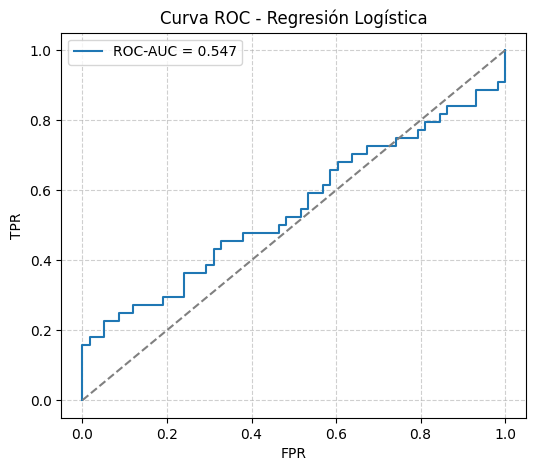


Métricas con umbral 0.7:
              precision    recall  f1-score   support

           0     0.5686    1.0000    0.7250        58
           1     0.0000    0.0000    0.0000        44

    accuracy                         0.5686       102
   macro avg     0.2843    0.5000    0.3625       102
weighted avg     0.3233    0.5686    0.4123       102

Matriz de confusión:
 [[58  0]
 [44  0]]


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_clas

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression 
#predice la probabilidad de que una obs pertenezca a una clase (quiebra = 1)
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve 
#roc_curve-> genera puntos para graficar la curva de ROC
import matplotlib.pyplot as plt


# 2) X, y (excluye Id)
y = df_clean_sin_outliers["Quiebra"].astype(int) #Asegura que sea de tipo INT
X = df_clean_sin_outliers.drop(columns=["Quiebra", "Id"], errors="ignore") #eliminamos quiebra e ID

# 3) Columnas numéricas y categóricas
num_cols = X.select_dtypes(include="number").columns.tolist() #columnas numéricas
cat_cols = X.select_dtypes(exclude="number").columns.tolist() #columnas categóricas

# 4) Preprocesamiento
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")), 
    #Rellena NaN con la mediana de cada columna
    ("sc", StandardScaler()), 
    #Normaliza los n para que tengan media 0 y desviacion 1
])
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    #Rellena NaN con la moda de cada columna
    ("ohe", OneHotEncoder(handle_unknown="ignore")) 
    #convierte cada categoria en columnas binarias
])
pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    #aplica la mediana a los datos nulos que se encuentran en num_cols
    ("cat", cat_pipe, cat_cols)
    #aplica la moda + oOneHotEnconder a los datos nulos que se encuentran en cat_cols
])

# 5) Modelo
logit = LogisticRegression(
    max_iter=1000, #Número maximo de iteraciones para que el modelo converja 
    #(llegar a un punto donde los coeficientes no cambien mucho)
    class_weight="balanced",   # ayuda con desbalance, 
    #ajustando los pesos de las clases automáticamente
    solver="lbfgs"  #util para optimizar los coeficientes. 
    #es rapido y estable para datasets no muy grandes
)

pipe = Pipeline([
    ("pre", pre), #Preprocesador que transforma numéricas y categóricas
    ("clf", logit) #el modelo de regresión logística
    #Con un solo .fit() o .predict() el pipeline hace todo el 
    # flujo automatico: imputacion, escalado, codificacion y entrenamietno.
])

# 6) Split estratificado si hay ambas clases
strat = y if y.value_counts().min() >= 2 else None 
#Si tiene minimo 2 ejemplos, asegura que la proporcion 
# de clases esten en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    #20% para prueba y 80% entrenamiento, reproducibilidad, 
    # mantiene proporcion de clases en ambos conjuntos
    X, y, test_size=0.2, random_state=42, stratify=strat
)

# 7) Entrenar y evaluar
pipe.fit(X_train, y_train) #entrena el modelo con los datos de entrenamiento
y_pred = pipe.predict(X_test) # Predice la clases (0 o 1) en el conjunto de pruebas
y_prob = pipe.predict_proba(X_test)[:, 1] #probabilidad de ser clase 1 (quiebra)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4)) 
#precision, recall, f1-score, support
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred)) 
#aciertos y errores por clase
try:
    print("ROC-AUC:", roc_auc_score(y_test, y_prob)) 
    #mide capacidad de discriminacion del modelo, usando probabilidades
except Exception:
    pass

# 8) Curva ROC (opcional) ROC -> Receiver Operating Characteristic
fpr, tpr, thr = roc_curve(y_test, y_prob) #calcula los puntos de la curva 
#[[False Positive Rate (falsos positivos/total negativos)], 
# [True Positive Rate (recall, verdaderos positivos/ total positivos)]
#[Los umbrales de decision usados para generar la curva (probabilidades entre 0 y 1)]]
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_prob):.3f}") 
#dibuja la curva roc: TPR vs FPR
#Roc-auc es el area bajo la curva, indica la capacidad de discriminar entre clases: 
# 0.5 modelo sin capacidad y 1 modelo perfecto
plt.plot([0,1],[0,1],"--", color="grey") #linea diagonal
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Curva ROC - Regresión Logística")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# 9) Ajuste de umbral (opcional): mejorar balance precisión/recall
best_t = 0.7  # pruébalo con 0.3–0.7 según tu caso
y_pred_t = (y_prob >= best_t).astype(int) 
#convierte las probabilidades predichas en etiquetas de clase (0 o 1), usando best_t
print(f"\nMétricas con umbral {best_t}:")
print(classification_report(y_test, y_pred_t, digits=4))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_t))


In [54]:
import pandas as pd
pd.read_csv("archivo.csv", sep=",", parse_dates=['fecha']) 
#lee el .CSV; sep=";" o "," segun el separador, parse_dates convierte a fecha.
df.drop(columns=[...], errors='ignore') #elimina una columna, si no existe no da error.
df.fillna(valor) # rellena valores nulos con otro valor
df.select_dtypes(include="number"/exclude="number") #selecciona las columnas numéricas o las excluye.
df.info() # ver tipos, nulos, filas/columnas.
df.describe(include="all"/ include=[object] o [float]/ exclude=[int] / percentiles=[0.1, 0.9]) 
# resumen estadistico según lo que se pida.
df.groupby("col")["otra_col"].mean() # agrupa y calcula el promedio.
df.reset_index(drop=True) # reinicia el indice, drop=True evita que el indice viejo se agregue como columna
pd.to_numeric(df['col'], errors='coerce') # convierte a numerico, si da error -> NaN
pd.to_datetime(df['col'], errors='coerce') # convierte a formato fecha, si da error -> NaT (Not-a-Time)

SyntaxError: invalid syntax (1617221594.py, line 6)

In [ ]:
import matplotlib.pyplot as plt
df["col"].hist(bins=30) #o plt.hist(columna, bins=30)
# Histograma de una columna; bins controla el numero de barras.
plt.boxplot(df["col"], vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue")) 
# Boxplot; vert=True lo muestra en vertical, patch_artist=True permite colores, 
# boxprops cambia estilo y el color de relleno.
plt.scatter(df["col1"], df["col2"], alpha=0.5) 
# Gráfico de dispersión (col1 vs col2); alpha controla transparencia.
plt.plot(x, y, label="línea") 
# Línea simple; label se usa para leyenda.
plt.axvline(x=valor, color="red", linestyle="--") 
# Línea vertical en x.
plt.axhline(y=valor, color="blue", linestyle=":") 
# Línea horizontal en y.
plt.title("Título del gráfico") 
plt.xlabel("Eje X") 
plt.ylabel("Eje Y") 
plt.legend() 
plt.grid(True, linestyle="--", alpha=0.6) 
# Personalización: títulos, etiquetas, leyenda, grilla.
plt.show() # muestra el gráfico.

import seaborn as sns
#Dibuja la matriz de correlación con un mapa de calor, 
# mostrando los valores en cada celda, con 2 decimales, 
#usando paleta de colores (azul -> rojo), mostrando la barra de colores al lado.
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  
#divide en entrenamiento (80%) y prueba (20%), semilla de reproducibilidad, 
# mantiene proporciones con stratify
GridSearchCV(modelo, param_grid, scoring="roc_auc", cv=5, n_jobs=-1)  
# busca mejores hiperparámetros probando combinaciones con validación cruzada.
#modelo -> puede ser pipeline o DecisionTreeClassifier
#param_grid -> parametros a probar como:
    # "clf__max_depth": [3, 5, 7, 9, None], #Profundidad maxima del arbol
    # "clf__min_samples_split": [2, 10, 20], #minimo de muestra para dividir un nodo
    # "clf__min_samples_leaf": [1, 5, 10], #minimo de muestras en una hoja
    # "clf__ccp_alpha": [0.0, 0.001, 0.01]  # poda mínima de coste
#scoring="roc_auc" -> métrica usada para evaluar
#cv=5 -> validacion cruzada con 5 particiones
#n_jobs=-1 -> es la cantidad de nucleos disponibles en la cpu que puede usar

In [ ]:
from sklearn.impute import SimpleImputer

SimpleImputer(strategy="median" o "mean") # rellena con mediana o media (numérico).
SimpleImputer(strategy="most_frequent") # rellena con moda (categórico).

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

OneHotEncoder(handle_unknown="ignore") 
#convierte columnas categoricas a columnas binarias, 
#Si en el conjunto de prueba apararece una categoria no vista en entranamiento,
#  lo ignora en vez de dar error
StandardScaler() #normaliza datos numericos (media = 0, varianza = 1)

In [ ]:
from sklearn.compose import ColumnTransformer

ColumnTransformer([
    ("num", num_pipe, num_cols),  
    # aplica a columnas numéricas
    ("cat", cat_pipe, cat_cols)   
    # aplica a categóricas
])

In [ ]:
from sklearn.pipeline import Pipeline

Pipeline([
    ("pre", preprocesamiento), 
    ("clf", modelo)
]) 
# encadena pasos: imputar → codificar → entrenar.

In [ ]:
import sklearn.tree import DecisionTreeClassifier, plot_tree

DecisionTreeClassifier(random_state=42, class_weight="balanced")  
# modelo árbol de decisión para clasificación, balancea clases
plot_tree(modelo, feature_names=features, class_names=["No","Sí"], filled=True)  
# visualiza el arbol con colores


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix 
from sklearn.metrics import roc_auc_score,roc_curve

classification_report(y_test, y_pred, digits=4)  
# muestra precisión, recall, F1-score, support
confusion_matrix(y_test, y_pred)  
# matriz de confusión.
#ej [[n veces predijo 0 y era 0; n veces predijo 1 pero era 0]
#    [n veces predijo 0 pero era 1: n veces predijo 1 y era 1]]
roc_auc_score(y_test, y_prob)  
# área bajo curva ROC.
roc_curve(y_test, y_prob)  
# coordenadas FPR y TPR para curva ROC.


In [ ]:
from sklearn.decomposition import PCA

PCA(n_components=0.95)   # conserva 95% de la varianza.
.fit(X)                  # ajusta componentes.
.transform(X)            # proyecta datos.
.fit_transform(X)        # ajusta y proyecta en un paso.
pca.explained_variance_ratio_  # varianza explicada por componente.


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier( #Armamos la red neuronal
    hidden_layer_sizes=(32, 16), 
    #Define la arquitectura de la red neuronal: 
    # 2 capas ocultas, la primera con 32 neuronas y la segunda con 16
    activation="relu", #La funcion de activacion en las neuronas es ReLU 
    #(Rectified Linear Unit), comun pq acelera y estabiliza el aprendizaje
    #puede ser relu, tanh, identity, logistic
    solver="adam", #Optimizador usado para ajustar los pesos de la red. 
    #Es una variante de gradiente descendente muy popular
    #puede ser adam, lbfgs,sgd
    max_iter=500, #número maximo de iteraciones (ciclos de entrenamiento)
    random_state=42 
    #fija la semilla aleatoria para que los resultados sean reproducibles
)
# .fit() -> entrena la red 
# .predict() predice las clases 

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n, random_state=42, n_init=n) 
#Queremos n grupos, fija la semilla en aleatorio para obtener los mismos clusters
#el algoritmo prueba n inicializaciones distintas y elige la mejor
# .fit(X_scaled) -> entrena el modelo con los datos escalados
# .predict(X_scaled) -> asigna cada dato a un cluster 
# .cluster_centers_ -> coordenadas de los centroides de los clusters